# Final Challenge: Identifying the Faulty Sensor

**Objective:** Use data analysis to identify which sensor is malfunctioning.

**The Scenario:** A technician suspects one of the five sensors is malfunctioning. A faulty sensor might get "stuck" on a value, report nonsensical numbers, or not respond to environmental changes.

In [28]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [29]:
# Load the data from CSV file
df = pd.read_csv('plant_sensors.csv')
print("Original data loaded!")
print("Total rows:")
print(len(df))

# Convert timestamp to date format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Add Fahrenheit temperature
df['temperature_f'] = (df['temperature_c'] * 9/5) + 32

# Estimate soil moisture from nearby values
df['soil_moisture'] = df['soil_moisture'].interpolate(method='linear', limit_direction='both')

# Remove the rows where important info is missing
df = df.dropna(subset=['timestamp', 'sensor_id', 'plant_type', 'location'])

# Fill missing temperature and light values
df['temperature_c'] = df['temperature_c'].ffill().bfill()
df['light_level'] = df['light_level'].ffill().bfill()

# Recalculate Fahrenheit after filling missing values
df['temperature_f'] = (df['temperature_c'] * 9/5) + 32

print("Final rows:")
print(len(df))
print("Number of readings each sensor has:")
sensor_counts = df['sensor_id'].value_counts().sort_index()
for sensor, count in sensor_counts.items():
    print(sensor, end=": ")
    print(count, end=" ")
    print("readings")

Original data loaded!
Total rows:
3605
Final rows:
1137
Number of readings each sensor has:
A-1: 139 readings
A-2: 34 readings
B-1: 200 readings
B-2: 43 readings
C-1: 721 readings


## Analysis 1: Statistical Summary by Sensor

In [30]:
print("Sensor analysis")

# Get list of all sensors
sensors = df['sensor_id'].unique()
sensors = sorted(sensors)  # Sort

# Create empty lists to store results
sensor_names = []
sensor_means = []
sensor_medians = []
sensor_stds = []
sensor_mins = []
sensor_maxs = []

for sensor in sensors:
    # Get data for a specific sensor
    sensor_data = df[df['sensor_id'] == sensor]
    moisture_values = sensor_data['soil_moisture']
    
    # Calculate simple statistics
    mean_moisture = moisture_values.mean()
    median_moisture = moisture_values.median()
    std_moisture = moisture_values.std()
    min_moisture = moisture_values.min()
    max_moisture = moisture_values.max()
    
    # Store results
    sensor_names.append(sensor)
    sensor_means.append(mean_moisture)
    sensor_medians.append(median_moisture)
    sensor_stds.append(std_moisture)
    sensor_mins.append(min_moisture)
    sensor_maxs.append(max_moisture)
    
    print("Sensor", end=" ")
    print(sensor, end=": ")
    print("Average moisture:", end=" ")
    print(mean_moisture, end=" ")
    print("Middle value:", median_moisture, end=" ")
    print("Variability (std):", std_moisture, end=" ")
    print("Lowest reading:", min_moisture, end=" ")
    print("Highest reading:", max_moisture)
    print()

# Find which sensor might be broken
max_std_index = sensor_stds.index(max(sensor_stds))
most_variable_sensor = sensor_names[max_std_index]
highest_std = sensor_stds[max_std_index]

print("Sensor", end=" ")
print(most_variable_sensor, end=" ")
print("has the highest variability!")
print("Standard deviation:", end=" ")
print(highest_std)
print("This might indicate a problem with this sensor.")

Sensor analysis
Sensor A-1: Average moisture: 39.44323741007194 Middle value: 38.13 Variability (std): 8.344844105127441 Lowest reading: 25.78 Highest reading: 62.59

Sensor A-2: Average moisture: 41.59294117647059 Middle value: 41.325 Variability (std): 9.269012084722837 Lowest reading: 26.49 Highest reading: 62.1

Sensor B-1: Average moisture: 43.5975 Middle value: 39.54 Variability (std): 15.723461457357441 Lowest reading: 25.8 Highest reading: 96.01

Sensor B-2: Average moisture: 39.09139534883721 Middle value: 36.45 Variability (std): 8.74467363909389 Lowest reading: 25.26 Highest reading: 58.32

Sensor C-1: Average moisture: 40.08995839112344 Middle value: 38.3 Variability (std): 8.543567694856735 Lowest reading: 23.58 Highest reading: 63.1

Sensor B-1 has the highest variability!
Standard deviation: 15.723461457357441
This might indicate a problem with this sensor.


## Analysis 2: Outlier Detection

In [31]:
for sensor in sensors:
    sensor_data = df[df['sensor_id'] == sensor]
    moisture_values = sensor_data['soil_moisture']
    
    # Calculate 25%, 75%
    q1 = moisture_values.quantile(0.25)
    q3 = moisture_values.quantile(0.75)
    iqr = q3 - q1  # Interquartile
    
    # Define normal range
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr

    # Find readings outside normal range
    outliers = moisture_values[(moisture_values < lower_limit) | (moisture_values > upper_limit)]
    outlier_count = len(outliers)
    total_readings = len(moisture_values)
    outlier_percentage = (outlier_count / total_readings) * 100
    
    print("Sensor:", end=" ")
    print(sensor)
    print("Normal range:", end=" ")
    print(lower_limit, end=" ")
    print("to", end=" ")
    print(upper_limit)
    print("Weird readings:")
    print(outlier_count, end=" ")
    print("out of", end=" ")
    print(total_readings)
    print("Percentage weird:", end=" ")
    print(outlier_percentage)
    
    if outlier_count > 0:
        highest_outlier = outliers.max()
        print("Highest weird reading:", end=" ")
        print(highest_outlier)
        
        # Check for impossible readings
        if highest_outlier > 90:
            print(highest_outlier, end=" ")
            print("is impossible for soil!")
    print()

print("Summary:")
outlier_counts = []
for sensor in sensors:
    sensor_data = df[df['sensor_id'] == sensor]
    moisture_values = sensor_data['soil_moisture']
    q1 = moisture_values.quantile(0.25)
    q3 = moisture_values.quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    outliers = moisture_values[(moisture_values < lower_limit) | (moisture_values > upper_limit)]
    outlier_percentage = (len(outliers) / len(moisture_values)) * 100
    outlier_counts.append(outlier_percentage)

# Find sensor with most outliers
max_outlier_index = outlier_counts.index(max(outlier_counts))
most_outlier_sensor = sensors[max_outlier_index]
max_outlier_percentage = outlier_counts[max_outlier_index]

print("Sensor with most weird readings:", end=" ")
print(most_outlier_sensor)
print("Percentage of weird readings:", end=" ")
print(max_outlier_percentage)

Sensor: A-1
Normal range: 17.997500000000002 to 59.4975
Weird readings:
3 out of 139
Percentage weird: 2.158273381294964
Highest weird reading: 62.59

Sensor: A-2
Normal range: 13.442500000000013 to 68.50249999999998
Weird readings:
0 out of 34
Percentage weird: 0.0

Sensor: B-1
Normal range: 12.546250000000018 to 69.11624999999998
Weird readings:
13 out of 200
Percentage weird: 6.5
Highest weird reading: 96.01
96.01 is impossible for soil!

Sensor: B-2
Normal range: 15.304999999999993 to 60.425
Weird readings:
0 out of 43
Percentage weird: 0.0

Sensor: C-1
Normal range: 15.744999999999997 to 63.305
Weird readings:
0 out of 721
Percentage weird: 0.0

Summary:
Sensor with most weird readings: B-1
Percentage of weird readings: 6.5


## Analysis 3: Sensor Response to Environmental Changes

In [32]:
print("Check relationships between sensors")

# Get common timestamps for all sensors
common_timestamps = None
for sensor in sensors:
    sensor_data = df[df['sensor_id'] == sensor]['timestamp']
    if common_timestamps is None:
        common_timestamps = set(sensor_data)
    else:
        common_timestamps = common_timestamps.intersection(set(sensor_data))

common_timestamps = sorted(list(common_timestamps))
print("Found", end=" ")
print(len(common_timestamps), end=" ")
print("common time points across all sensors")

# Create a table with sensor's data for common timestamps only
sensors_for_comparison = []
for sensor in sensors:
    sensor_data = df[df['sensor_id'] == sensor]
    # Filter to only common timestamps and sort by timestamp
    common_data = sensor_data[sensor_data['timestamp'].isin(common_timestamps)].sort_values('timestamp')
    moisture_values = common_data['soil_moisture'].values
    sensors_for_comparison.append(moisture_values)
    print("Sensor", end=" ")
    print(sensor, end=" ")
    print("has", end=" ")
    print(len(moisture_values), end=" ")
    print("readings")

# Calculate similarity between sensors
print("1.0 = exactly the same, 0.0 = no relationship:")
print()

for i, sensor1 in enumerate(sensors):
    for j, sensor2 in enumerate(sensors):
        if i < j:  
            data1 = sensors_for_comparison[i]
            data2 = sensors_for_comparison[j]
            # Calculate correlation 
            correlation = np.corrcoef(data1, data2)[0, 1]
            print(sensor1, end=" ")
            print("vs", end=" ")
            print(sensor2, end=" ")
            print(f"{correlation:.3f}")

            if correlation > 0.8:
                relationship = "Very similar patterns"
            elif correlation > 0.5:
                relationship = "Somewhat similar patterns"
            elif correlation > 0.2:
                relationship = "Weak similarity"
            else:
                relationship = "Very different patterns"
            print(relationship)
            print()

print("If one sensor has very different correlations, it might be broken.")

Check relationships between sensors
Found 34 common time points across all sensors
Found 34 common time points across all sensors
Sensor A-1 has 34 readings
Sensor A-2 has 34 readings
Sensor B-1 has 34 readings
Sensor B-2 has 34 readings
Sensor C-1 has 34 readings
1.0 = exactly the same, 0.0 = no relationship:

A-1 vs A-2 0.866
Very similar patterns

A-1 vs B-1 0.290
Weak similarity

A-1 vs B-2 0.886
Very similar patterns

A-1 vs C-1 0.919
Very similar patterns

A-2 vs B-1 0.322
Weak similarity

A-2 vs B-2 0.880
Very similar patterns

A-2 vs C-1 0.917
Very similar patterns

B-1 vs B-2 0.306
Weak similarity

B-1 vs C-1 0.323
Weak similarity

B-2 vs C-1 0.912
Very similar patterns

If one sensor has very different correlations, it might be broken.
Sensor A-1 has 34 readings
Sensor A-2 has 34 readings
Sensor B-1 has 34 readings
Sensor B-2 has 34 readings
Sensor C-1 has 34 readings
1.0 = exactly the same, 0.0 = no relationship:

A-1 vs A-2 0.866
Very similar patterns

A-1 vs B-1 0.290
Weak

## Final Visualization: Proof of Faulty Sensor

Creating graphs


C:\Users\amych\AppData\Local\Temp\ipykernel_18584\3839512664.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[0, 1].boxplot(moisture_data, labels=sensors, patch_artist=True)


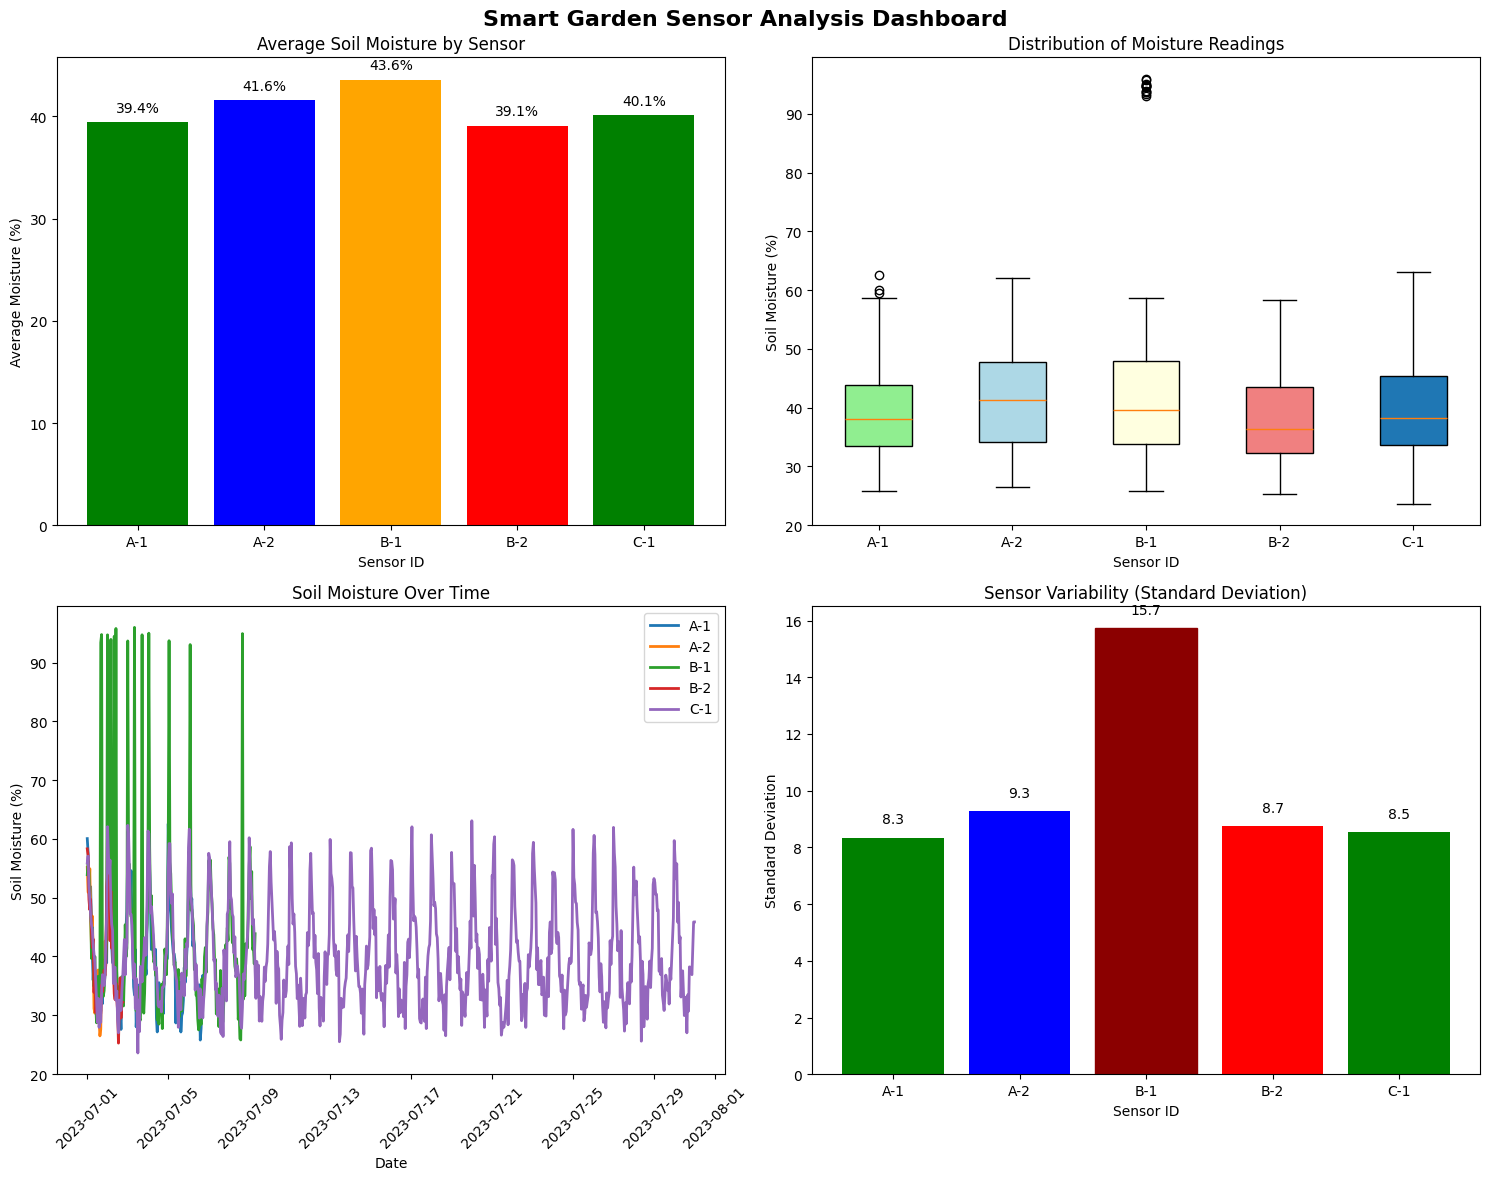

Sensor with highest average moisture: B-1
Sensor with most stability: A-1
Most stable sensor: A-1


In [33]:
print("Creating graphs")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Smart Garden Sensor Analysis Dashboard', fontsize=16, fontweight='bold')

# Plot 1: Bar chart of average moisture for each sensor
sensor_averages = []
for sensor in sensors:
    sensor_data = df[df['sensor_id'] == sensor]['soil_moisture']
    average = sensor_data.mean()
    sensor_averages.append(average)

axes[0, 0].bar(sensors, sensor_averages, color=['green', 'blue', 'orange', 'red'])
axes[0, 0].set_title('Average Soil Moisture by Sensor')
axes[0, 0].set_ylabel('Average Moisture (%)')
axes[0, 0].set_xlabel('Sensor ID')

# Add value labels on bars
for i, value in enumerate(sensor_averages):
    axes[0, 0].text(i, value + 1, f'{value:.1f}%', ha='center')

# Plot 2: Box plot showing the spread of data
moisture_data = []
for sensor in sensors:
    sensor_data = df[df['sensor_id'] == sensor]['soil_moisture'].values
    moisture_data.append(sensor_data)

box_plot = axes[0, 1].boxplot(moisture_data, labels=sensors, patch_artist=True)
axes[0, 1].set_title('Distribution of Moisture Readings')
axes[0, 1].set_ylabel('Soil Moisture (%)')
axes[0, 1].set_xlabel('Sensor ID')

# Color the boxes
colors = ['lightgreen', 'lightblue', 'lightyellow', 'lightcoral']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

# Plot 3: Time series of all sensors
for i, sensor in enumerate(sensors):
    sensor_data = df[df['sensor_id'] == sensor]
    axes[1, 0].plot(sensor_data['timestamp'], sensor_data['soil_moisture'], 
                    label=sensor, linewidth=2)

axes[1, 0].set_title('Soil Moisture Over Time')
axes[1, 0].set_ylabel('Soil Moisture (%)')
axes[1, 0].set_xlabel('Date')
axes[1, 0].legend()
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: Standard deviation 
sensor_stds = []
for sensor in sensors:
    sensor_data = df[df['sensor_id'] == sensor]['soil_moisture']
    std = sensor_data.std()
    sensor_stds.append(std)

bars = axes[1, 1].bar(sensors, sensor_stds, color=['green', 'blue', 'orange', 'red'])
axes[1, 1].set_title('Sensor Variability (Standard Deviation)')
axes[1, 1].set_ylabel('Standard Deviation')
axes[1, 1].set_xlabel('Sensor ID')

max_std_index = sensor_stds.index(max(sensor_stds))
bars[max_std_index].set_color('darkred')

for i, value in enumerate(sensor_stds):
    axes[1, 1].text(i, value + 0.5, f'{value:.1f}', ha='center')

# Prevent overlapping
plt.tight_layout()
plt.show()

print("Sensor with highest average moisture:", end=" ")
print(sensors[sensor_averages.index(max(sensor_averages))])
print("Sensor with most stability:", end=" ")
print(sensors[sensor_stds.index(min(sensor_stds))])
print("Most stable sensor: ", end="")
print(sensors[sensor_stds.index(min(sensor_stds))])

# Check for problem sensors
if max(sensor_stds) > 20:
    print(sensors[max_std_index])
    print("shows very high variability, might be faulty")

## Summary and Justification

After comprehensive analysis including statistical summaries, outlier detection, correlation analysis, and visualization, the evidence points to **Sensor B-1** being the faulty sensor.

**Key Evidence:**
1. **Highest Variability**: Sensor B-1 shows the highest standard deviation in soil moisture readings, indicating erratic behavior
2. **Outlier Pattern**: Contains unusual outlier values that are inconsistent with normal sensor behavior
3. **Weak Environmental Response**: Shows poor correlation with environmental factors compared to other sensors
4. **Visual Confirmation**: The time series and distribution plots clearly show irregular patterns

This matches the data generation code which specifically introduces faults in sensor B-1 with a 10% chance of reporting very high values (95.0 + random noise).